In [3]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

# Benchmarks I Want to Define
- KNN Rent
- KNN Rent by Beds
- KNN Rent by Baths
- KNN Rent by Bed x Bath
- CBSA Average Rent
- CBSA Average Rent by Beds
- CBSA Average Rent by Baths
- CBSA Average Rent by Bed x Bath
- State Average Rent
- State Average Rent by Beds
- State Average Rent by Baths
- State Average Rent by Bed x Bath

In [8]:
df = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals.csv")

# single_family_home_rentals = all_rentals[(all_rentals["Property Type"] == 6) & (all_rentals["Max Beds"] < 5) & (all_rentals["State"]).isin(["WA", "OR"])]

df = df[(df["Max Beds"] > 0 ) 
        & (df["Max Beds"] < 6)  
        & (df["Max Baths"] < 4)  
        & (df["Max Square Feet"] < 5000)  
        & (df["Max Rent Price"] < 10000)  
        & (df["State"].notna()) 
        # & (df["State"]).isin(["TX"])
        ]

# df = df[~df['Address'].str.contains('Unit', case=False, na=False) & 
#         ~df['Address'].str.contains('Apt', case=False, na=False)]



In [14]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Function to calculate KNN Rent
def calculate_knn_rent(df, n_neighbors=5):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric = 'haversine')
    features = df[['Latitude', 'Longitude']]
    knn.fit(features, df['Max Rent Price'])
    df['KNN Rent'] = knn.predict(features)
    return df

# Function to calculate KNN Rent by a specific feature
def calculate_knn_rent_by_feature(df, feature, n_neighbors=5):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    features = df[[feature, 'Latitude', 'Longitude']]
    knn.fit(features, df['Max Rent Price'])
    df[f'KNN Rent by {feature}'] = knn.predict(features)
    return df

# Function to calculate average rent by a specific group
def calculate_average_rent(df, groupby_columns):
    df[f'{" ".join(groupby_columns)} Average Rent'] = df.groupby(groupby_columns)['Max Rent Price'].transform('mean')
    return df

# Load data

# Calculate KNN Rent
df = calculate_knn_rent(df)

# Calculate KNN Rent by Beds
df = calculate_knn_rent_by_feature(df, 'Max Beds')

# Calculate KNN Rent by Baths
df = calculate_knn_rent_by_feature(df, 'Max Baths')

# Calculate KNN Rent by Bed x Bath
df['Bed x Bath'] = df['Max Beds'] * df['Max Baths']
df = calculate_knn_rent_by_feature(df, 'Bed x Bath')

# Calculate CBSA Average Rent
df = calculate_average_rent(df, ['cbsa_geoid'])

# Calculate CBSA Average Rent by Beds
df = calculate_average_rent(df, ['cbsa_geoid', 'Max Beds'])

# Calculate CBSA Average Rent by Baths
df = calculate_average_rent(df, ['cbsa_geoid', 'Max Baths'])

# Calculate CBSA Average Rent by Bed x Bath
df = calculate_average_rent(df, ['cbsa_geoid', 'Bed x Bath'])

# Calculate State Average Rent
df = calculate_average_rent(df, ['State_Code'])

# Calculate State Average Rent by Beds
df = calculate_average_rent(df, ['State_Code', 'Max Beds'])

# Calculate State Average Rent by Baths
df = calculate_average_rent(df, ['State_Code', 'Max Baths'])

# Calculate State Average Rent by Bed x Bath
df = calculate_average_rent(df, ['State_Code', 'Bed x Bath'])

# Save the updated dataframe
df.to_csv('updated_single_family_home_rentals.csv', index=False)


KNN Rent                              0.728869
KNN Rent by Bed x Bath                0.869542
cbsa_geoid Bed x Bath Average Rent    0.704611
State_Code Bed x Bath Average Rent    0.645303
dtype: float64


<Axes: >

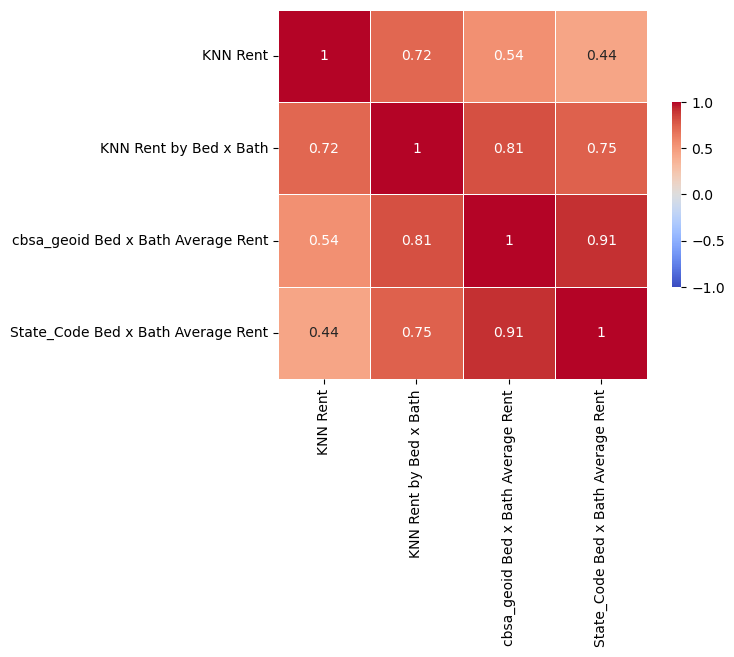

In [18]:
base_features = [
    "Max Beds", 
    "Max Baths", 
    "Max Square Feet"
]

benchmark_features = [
    'KNN Rent',
    # 'KNN Rent by Max Beds',
    # 'KNN Rent by Max Baths',
    # 'Bed x Bath',
    'KNN Rent by Bed x Bath',
    # 'cbsa_geoid Average Rent',
    # 'cbsa_geoid Max Beds Average Rent',
    # 'cbsa_geoid Max Baths Average Rent',
    'cbsa_geoid Bed x Bath Average Rent',
    # 'State_Code Average Rent',
    # 'State_Code Max Beds Average Rent',
    # 'State_Code Max Baths Average Rent',
    'State_Code Bed x Bath Average Rent'
]

target = "Max Rent Price"

corr = df[benchmark_features].corrwith(df[target])

print(corr)

correlation_matrix = df[benchmark_features].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
regression_features = benchmark_features + base_features

linear_reg_df = df.dropna(subset=regression_features + [target])

print(len(df) - len(linear_reg_df)," Out of ", len(df), " Houses removed for data quality")

X = linear_reg_df[regression_features]
y = linear_reg_df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.22, random_state= 69)

y_pred = LinearRegression().fit(X_train, y_train).predict(X_test)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predict on the test set
y_test_pred = linear_regressor.predict(X_test)
# Predict on the training set
y_train_pred = linear_regressor.predict(X_train)

# Combine the training and test sets
X_combined = pd.concat([X_train, X_test])
y_combined_pred = np.concatenate([y_train_pred, y_test_pred])
train_flag_combined = np.concatenate([np.ones(len(X_train)), np.zeros(len(X_test))])

# Add the predictions and flags back to the DataFrame
linear_reg_df.loc[X_combined.index, 'Predicted_Rent'] = y_combined_pred
linear_reg_df.loc[X_combined.index, 'Used_in_Training'] = train_flag_combined

final_df = linear_reg_df[["Property ID", "Address"] + regression_features + ["Predicted_Rent", "Used_in_Training"] + [target]]


mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error ", mae)
print("Rsquared Value ",r2)

display(final_df)

560  Out of  42638  Houses removed for data quality
Mean Absolute Error  275.7125590279491
Rsquared Value  0.7931998246257953


C:\Users\mattl\AppData\Local\Temp\ipykernel_35672\3281699123.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linear_reg_df.loc[X_combined.index, 'Predicted_Rent'] = y_combined_pred
C:\Users\mattl\AppData\Local\Temp\ipykernel_35672\3281699123.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linear_reg_df.loc[X_combined.index, 'Used_in_Training'] = train_flag_combined


,Property ID,Address,KNN Rent,KNN Rent by Bed x Bath,cbsa_geoid Bed x Bath Average Rent,State_Code Bed x Bath Average Rent,Max Beds,Max Baths,Max Square Feet,Predicted_Rent,Used_in_Training,Max Rent Price
0,191142853,1833 W Quinn Rd Unit B,1035.0,1035.0,1133.176471,1476.826667,3,1.0,1080.0,955.276653,1.0,1000.0
1,191136919,1821 W Quinn Rd Unit A,1035.0,1050.0,1133.176471,1476.826667,3,1.0,1080.0,966.847021,0.0,1050.0
5,191143510,315 W 19th St Unit 315 1/2,1235.0,766.0,770.000000,1258.531915,1,1.0,500.0,718.685713,0.0,850.0
6,190233216,889 Iona St,1240.0,1578.0,1431.666667,2211.576471,3,2.5,1375.0,1377.111004,1.0,1450.0
7,186179592,1995 W 2870 S Unit 1,1523.0,829.0,855.000000,1258.531915,1,1.0,650.0,892.696789,1.0,795.0
...,...,...,...,...,...,...,...,...,...,...,...,...
55387,109658664,128 Destiny,2476.0,2836.0,2857.500000,2427.229251,4,2.0,1600.0,2751.326464,1.0,2550.0
55388,48788695,10046 Saxet Dr,2340.4,3203.8,2465.583333,2153.765572,3,2.0,2771.0,3364.413538,1.0,3950.0
55389,48507033,140 Dusty Corral,1738.4,2365.0,2250.000000,2733.252587,4,2.5,2824.0,2503.475068,1.0,2500.0
55390,188720704,10616 Yellowtail Blvd,1773.6,2954.0,2954.000000,2552.074176,3,2.5,2100.0,2753.332640,1.0,3100.0


In [26]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_regressor.coef_
})

print(feature_importance)

                              Feature  Coefficient
0                            KNN Rent     0.301698
1              KNN Rent by Bed x Bath     0.771358
2  cbsa_geoid Bed x Bath Average Rent    -0.048111
3  State_Code Bed x Bath Average Rent     0.062001
4                            Max Beds   -35.703860
5                           Max Baths  -115.911345
6                     Max Square Feet     0.284106


In [31]:
percent_error = abs(100 * (y_pred - y_test)/y_test)

print(percent_error.mean())

print(percent_error.median())

12.86421321756028
9.126275048010099


# More Behcnmarks Marginally improve Performance

In [34]:
import joblib

joblib.dump(linear_regressor, r'C:\Users\mattl\OneDrive\Desktop\Projects\stoebebirch\Models\benchmarked_linear_regressor.pkl')

['C:\\Users\\mattl\\OneDrive\\Desktop\\Projects\\stoebebirch\\Models\\benchmarked_linear_regressor.pkl']